# Sentiment Analysis

## 1.0 Business understanding

### 1.1 Business objective

### 1.2 Situational assessment

* Weather forecasts are vital to people, businesses, and governments.
* Weather forecasting is challenging due to the nonlinear nature of the data.
* Numeical weather prediction has continuously improved but is still uncertain and inaccurate.
* Neural networks (NN) are the most pervasive machine learning tools used in forecasting.
* NNs are well suited to improve the reliability and accuracy of weather forecasts because they are designed to deal with conplex nonlinear data.

**Research Question #1:**
Can historical time series temperature data be used to forecast future temperatures?

**Hypothesis Couplet**

Null Hypothesis (H<sub>0</sub>): Historical time series temperature data cannot be used to accurately forecast future temperatures.


Alternate Hypothesis (H<sub>1</sub>): Historical time series temperature data can be used to accurately forecast future temperatures.


## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Data mining goals

#### 2.1.2 Import libraries

In [1]:
!pip install -U spacy

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
import spacy
import tensorflow as tf
import tensorflow_datasets as tfds
import nltk
import re
import string
import pickle

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from keras.optimizers.legacy import Adam as LegacyAdam, SGD as LegacySGD
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model
from sklearn.tree import plot_tree
import networkx as nx
from itertools import product

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

In [4]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


#### 2.1.3 Suppress warnings

In [5]:
warnings.filterwarnings('ignore')

#### 2.1.4 Data ingestion

In [6]:
# Import dataset
#create 2-dimensional dataFrames from a imported data.
#Choose the local file (baseball.csv).
#NOTE: YOU WILL NEED TO ALLOW THIRD-PARTY COOKIES FROM THIS SITE colab.research.google.com
from google.colab import files
uploaded = files.upload()

Saving training.1600000.processed.noemoticon.csv to training.1600000.processed.noemoticon (2).csv


In [7]:
file_name = "training.1600000.processed.noemoticon.csv"

In [8]:
# Load dataset
df=pd.read_csv(file_name, encoding='latin', names = ['polarity', 'id', 'date', 'query', 'user', 'text'])

In [9]:
df = df.sample(frac=1)
df = df[:200000]

In [10]:
print("Dataset shape", df.shape)

Dataset shape (200000, 6)


In [11]:
pd.set_option('display.max_columns', None)
df.head()

,polarity,id,date,query,user,text
1534543,4,2178790459,Mon Jun 15 08:12:31 PDT 2009,NO_QUERY,janella09,wait! I Did It For You - David Cook. Love it.
76264,0,1695547197,Mon May 04 06:24:07 PDT 2009,NO_QUERY,smileyceexox,Guys my back hurts and so does my stomach.
365314,0,2048492506,Fri Jun 05 15:17:15 PDT 2009,NO_QUERY,DawnMJ804,I'm doing nothing and because of that I'm slee...
541223,0,2200019403,Tue Jun 16 18:19:35 PDT 2009,NO_QUERY,lamilondon,@melondeck I kno ium hungry
1283820,4,2001983330,Tue Jun 02 02:44:59 PDT 2009,NO_QUERY,alex_vance,@zenthetiger yes! I need a fellow scifi nut to...


#### 2.1.5 Data description

**High Level Data Dictionary**

* ID: unique identification numer
* date : the date of the tweet (Sat May 16 23:58:44 PDT 2009)
* polarity : the polarity of the tweet (0 = negative 4 = positive)
* user : the user that tweeted (TerraScene)
* text : the text of the tweet (i'm 10x cooler than all of you)
* query: NO_QUERY

In [12]:
df.columns

Index(['polarity', 'id', 'date', 'query', 'user', 'text'], dtype='object')

In [13]:
df.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,1.992060,1.998384e+09
std,1.999989,1.937877e+08
min,0.000000,1.467810e+09
25%,0.000000,1.956928e+09
50%,0.000000,2.002114e+09
75%,4.000000,2.176895e+09
max,4.000000,2.329206e+09


In [14]:
df.describe(include='object')

,date,query,user,text
count,200000,200000,200000,200000
unique,175423,1,148529,199145
top,Sun May 31 13:10:34 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,6,200000,71,21


#### 2.1.6 Change positive polarity value from 4 to 1

In [15]:
df['polarity'] = df['polarity'].replace(4,1)
df.head()

,polarity,id,date,query,user,text
1534543,1,2178790459,Mon Jun 15 08:12:31 PDT 2009,NO_QUERY,janella09,wait! I Did It For You - David Cook. Love it.
76264,0,1695547197,Mon May 04 06:24:07 PDT 2009,NO_QUERY,smileyceexox,Guys my back hurts and so does my stomach.
365314,0,2048492506,Fri Jun 05 15:17:15 PDT 2009,NO_QUERY,DawnMJ804,I'm doing nothing and because of that I'm slee...
541223,0,2200019403,Tue Jun 16 18:19:35 PDT 2009,NO_QUERY,lamilondon,@melondeck I kno ium hungry
1283820,1,2001983330,Tue Jun 02 02:44:59 PDT 2009,NO_QUERY,alex_vance,@zenthetiger yes! I need a fellow scifi nut to...


### 2.2 Data quality

#### 2.2.1 Check for missing values

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 1534543 to 873465
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   id        200000 non-null  int64 
 2   date      200000 non-null  object
 3   query     200000 non-null  object
 4   user      200000 non-null  object
 5   text      200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


There are no missing values.

#### 2.2.2 Check for outliers

The only two numeric features are ID and polarity.

#### 2.2.3 Check for duplicates

In [17]:
df.duplicated().sum()

np.int64(0)

There are no duplicate rows.

### 2.3 Exploratory data analysis

#### 2.3.1 Check the number of postive and negative tagged sentences

In [18]:
positives = df['polarity'][df.polarity == 1 ]
negatives = df['polarity'][df.polarity == 0 ]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         200000
No. of positve tagged sentences is:  99603
No. of negative tagged sentences is: 100397


#### 2.3.2 Plot word count distribution for poitive and negative polarity

In [19]:
def word_count(words):
    return len(words.split())

In [20]:
df['word count'] = df['text'].apply(word_count)
p = df['word count'][df.polarity == 1]
n = df['word count'][df.polarity == 0]

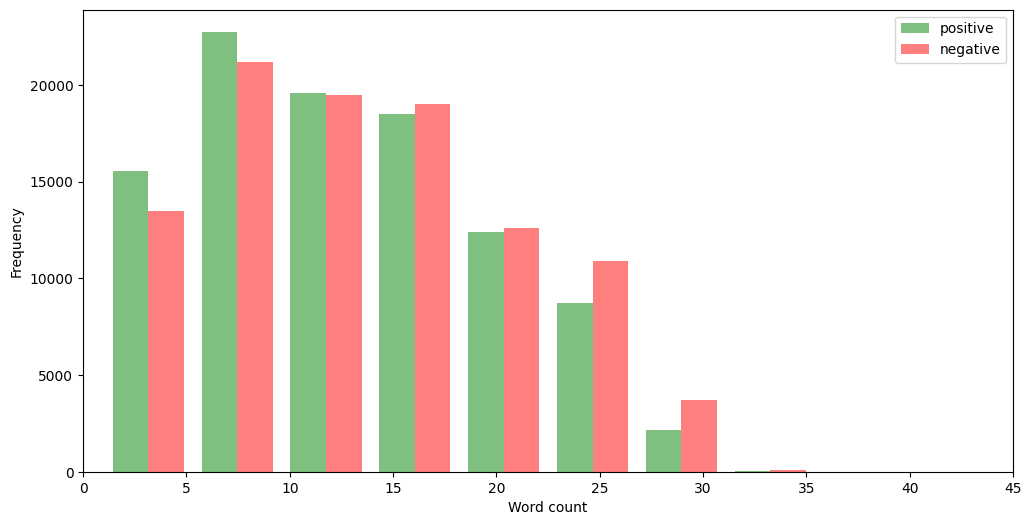

In [21]:
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.show()

#### 2.3.3 Common words in training data

In [22]:
all_words = []

In [23]:
for line in list(df['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())

In [24]:
Counter(all_words).most_common(20)

[('the', 65043),
 ('and', 36864),
 ('you', 29804),
 ('for', 26649),
 ('have', 17737),
 ('that', 16120),
 ("i'm", 15986),
 ('just', 15665),
 ('but', 15656),
 ('with', 14247),
 ('was', 12913),
 ('not', 12631),
 ('this', 11052),
 ('get', 10042),
 ('good', 9773),
 ('like', 9557),
 ('are', 9486),
 ('all', 9277),
 ('out', 8575),
 ('your', 8027)]

#### 2.3.4 Check corrleations of numeric variables

The only two numeric features are ID and polarity.

#### 2.3.5 Number of observations by polarity

In [25]:
def polarity_observations(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='polarity', data=df)
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Polarity Observation Count')
  plt.show()

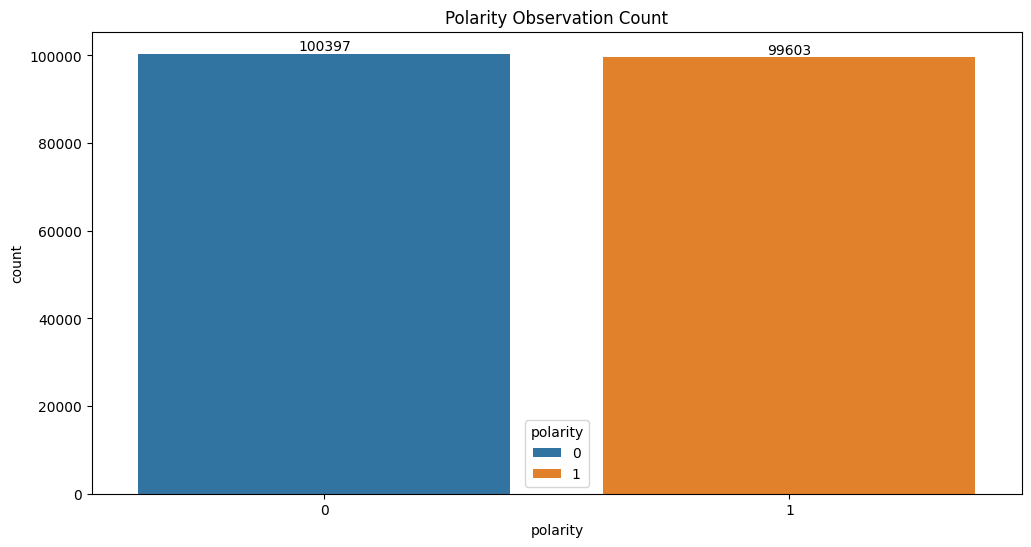

In [26]:
polarity_observations('polarity')

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 No missing values

#### 3.1.2 No duplicate rows

#### 3.1.3 No highly correlated features

#### 3.1.4 Drop unnecessary features

In [27]:
df.drop(['id', 'date','query','user','word count'], axis=1, inplace=True)
df.head()

,polarity,text
1534543,1,wait! I Did It For You - David Cook. Love it.
76264,0,Guys my back hurts and so does my stomach.
365314,0,I'm doing nothing and because of that I'm slee...
541223,0,@melondeck I kno ium hungry
1283820,1,@zenthetiger yes! I need a fellow scifi nut to...


### 3.2 Feature engineering

#### 3.2.1 Convert object to text

In [28]:
df['text'] = df['text'].astype('str')

#### 3.2.2 Download natural language toolkit features

In [29]:
nltk.download('stopwords', download_dir='/content/nltk_data')

# Add that directory to NLTK's search path
nltk.data.path.append('/content/nltk_data')

# Now load stopwords safely
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
#nltk.download('stopwords')
#stopword = set(stopwords.words('english'))
print(stopword)

{'myself', "we're", 'up', "you're", 'she', 'now', "they've", 'am', 'don', "you've", 'few', "it's", 'did', 'with', 'own', "should've", "aren't", 'against', 'during', 'which', 'their', "don't", 'of', 'have', 'be', 'itself', 'so', 'before', "it'll", "you'd", "he'd", 'an', 'where', 'll', 'being', 'between', 'ma', "shan't", 'herself', 's', 'her', 'who', 'then', "we'll", 'haven', 'we', 'is', 'other', 'had', 'ain', 'than', "i've", 'into', 'for', "hadn't", 'any', 'this', 'does', 'mightn', "wasn't", 'shan', 'here', "he'll", 'only', 'yourself', "mustn't", 'wasn', 'wouldn', 'above', "you'll", 'after', 'by', "that'll", 'because', 'below', 'it', 'if', 'won', 'no', 'all', 'further', 'hadn', "i'm", 'doesn', "doesn't", 'on', 'those', 'your', 're', 'under', 'i', 'o', 'were', 'off', "isn't", 'not', 'just', 'in', "shouldn't", 'weren', 'his', 'down', 't', "mightn't", 'are', 'him', 'been', 'while', 'd', 'at', "i'd", 'some', 'shouldn', 'm', 'from', "couldn't", 'has', "weren't", 'most', 'themselves', 'hers',

In [33]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### 3.3.3 Patterns to recognize

#### 3.3.4 Natural language processing (lower casing, tokenization, lemmatizing, and removal of URLs, usernames, punctuation, shortwords, and stop words)

In [35]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

In [36]:
def spacy_tokenizer(text):
    # Pre-clean URLs and usernames
    text = re.sub(r"(http\S+|www\S+|@\w+)", "", text.lower())
    doc = nlp(text)
    return [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and len(token.text) > 1
    ]

In [37]:
def process_text(text):
    try:
        return " ".join(spacy_tokenizer(text))
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

In [38]:
df['processed_text'] = df['text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [34]:
df.head()

,polarity,text,processed_text
742536,0,doing homework again.........,oing homework again
1297288,1,@roomcmoo Thank you,roomcmoo thank you
167849,0,I want it to be 5 already,want it to be 5 already
491315,0,1 hour countdown and the dam day is over!! got...,hour countdown and the dam day is over got to...
102507,0,Soooo tired!!! 2 more days until I go back to ...,oooo tired 2 more days until i go back to work


#### 3.2.3 Word clouds

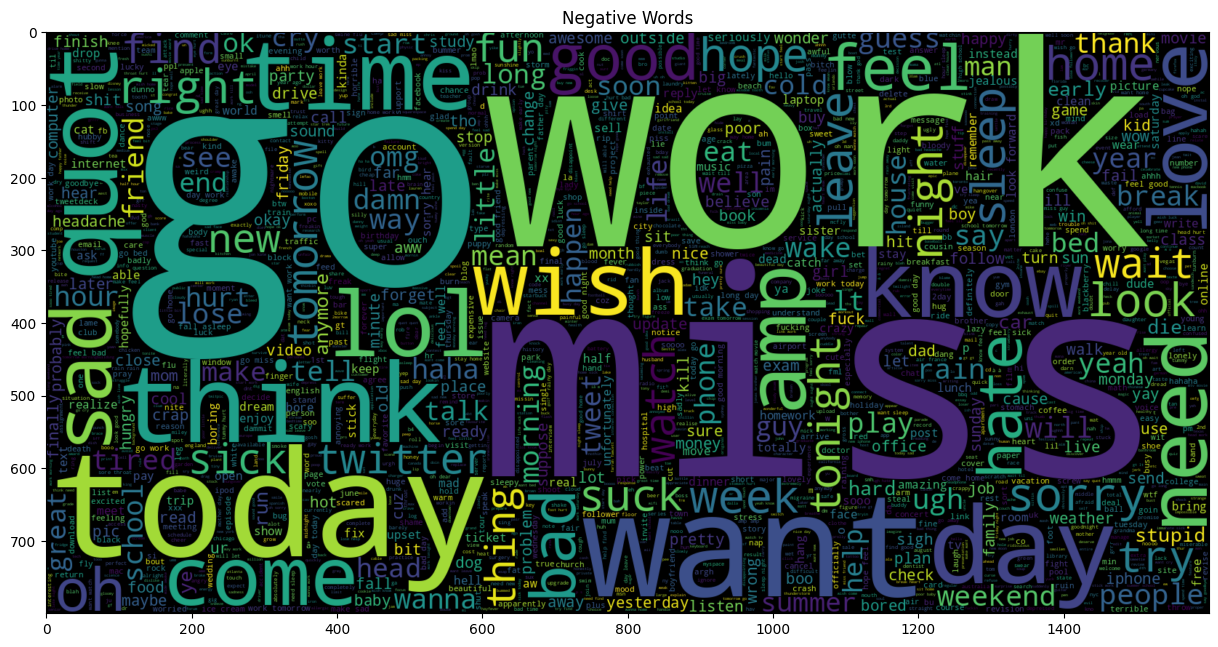

In [41]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.polarity == 0].processed_text))
plt.title('Negative Words')
plt.imshow(wc , interpolation = 'bilinear')

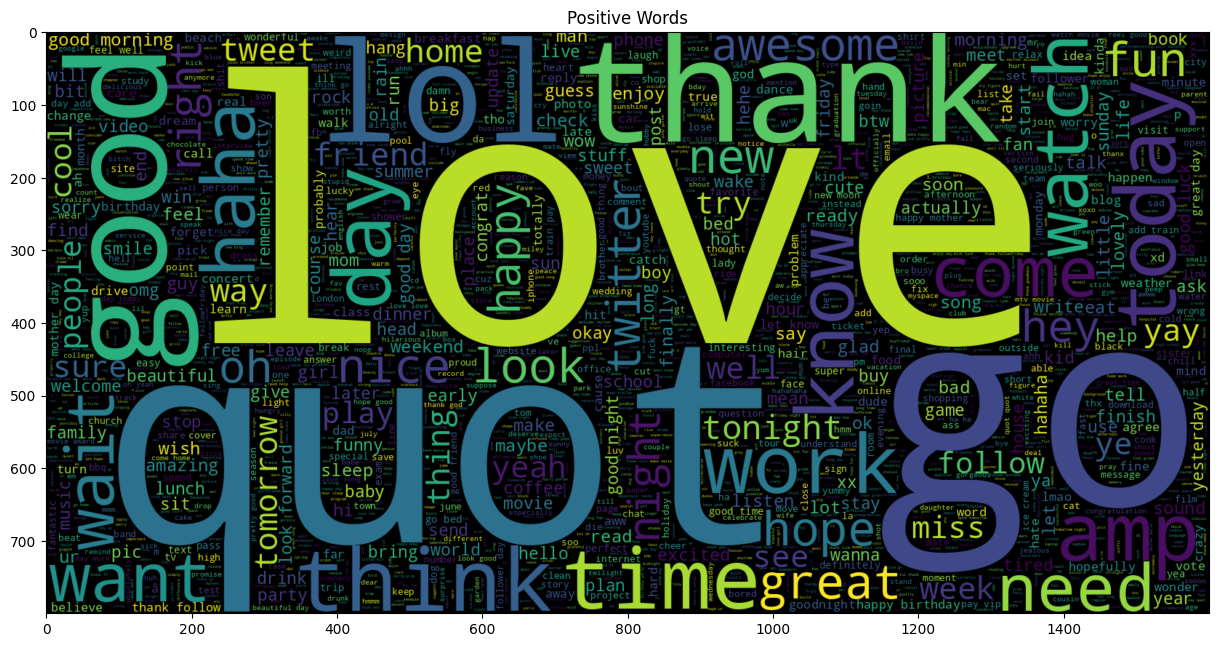

In [42]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.polarity == 1].processed_text))
plt.title('Positive Words')
plt.imshow(wc , interpolation = 'bilinear')

### 3.3 Data partitioning

In [43]:
X = df['processed_text'].values
y = df['polarity'].values

In [44]:
X.shape, y.shape

((200000,), (200000,))

### 3.4 Data transformation

#### 3.4.1 Convert text to word frequency vectors using term frequency - inverse document frequency (TF-IDF)

In [45]:
vector = TfidfVectorizer(sublinear_tf=True)

In [46]:
X = vector.fit_transform(X)

In [48]:
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names_out()))

Vector fitted.
No. of feature_words:  73517


In [49]:
X.shape, y.shape

((200000, 73517), (200000,))

#### 3.4.2 Train, test split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [51]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 73517)
y_train (160000,)

X_test (40000, 73517)
y_test (40000,)


## 4.0 Modeling

### 4.1.Logistic regression

In [52]:
lg = LogisticRegression()

In [53]:
history=lg.fit(X_train, y_train)

### 4.2 Linear support vector machine (SVM)

In [54]:
svm = LinearSVC()

In [55]:
svm.fit(X_train, y_train)

LinearSVC()

### 4.3 Random forest

In [56]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)

In [57]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=20)

### 4.4 Naive Bayes

In [58]:
nb = BernoulliNB()

In [59]:
nb.fit(X_train, y_train)

BernoulliNB()

### 4.5 Recurrent neural network (RNN)

,Validation Predictions,Actuals
0,11.134579,10.444444
1,10.270570,8.888889
2,8.793946,8.888889
3,8.771845,9.238889
4,9.163203,7.777778
...,...,...
4995,15.496911,15.355556
4996,15.209193,14.977778
4997,15.090055,13.916667
4998,13.903873,14.977778


## 5.0 Evaluation

In [60]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)

    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### 5.1 Logistic regression

Accuracy of model on training data : 80.22375000000001
Accuracy of model on testing data : 75.4975 

              precision    recall  f1-score   support

           0       0.77      0.73      0.75     20063
           1       0.74      0.78      0.76     19937

    accuracy                           0.75     40000
   macro avg       0.76      0.76      0.75     40000
weighted avg       0.76      0.75      0.75     40000



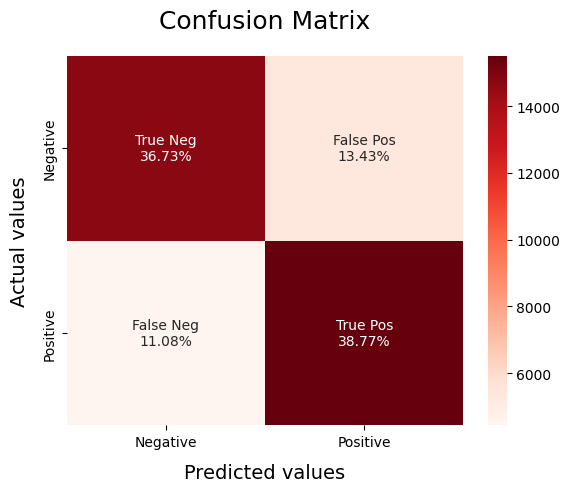

In [61]:
model_Evaluate(lg)

### 5.2 Linear SVM

Accuracy of model on training data : 85.2375
Accuracy of model on testing data : 74.24 

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     20063
           1       0.73      0.76      0.75     19937

    accuracy                           0.74     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.74      0.74      0.74     40000



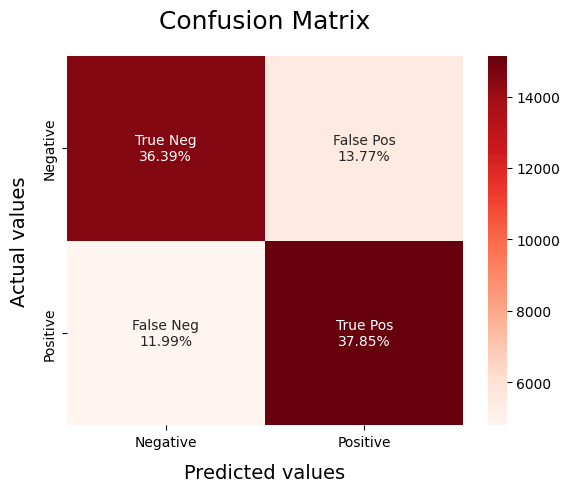

In [62]:
model_Evaluate(svm)

### 5.3 Random forest

Accuracy of model on training data : 75.981875
Accuracy of model on testing data : 71.52 

              precision    recall  f1-score   support

           0       0.75      0.65      0.70     20063
           1       0.69      0.78      0.73     19937

    accuracy                           0.72     40000
   macro avg       0.72      0.72      0.71     40000
weighted avg       0.72      0.72      0.71     40000



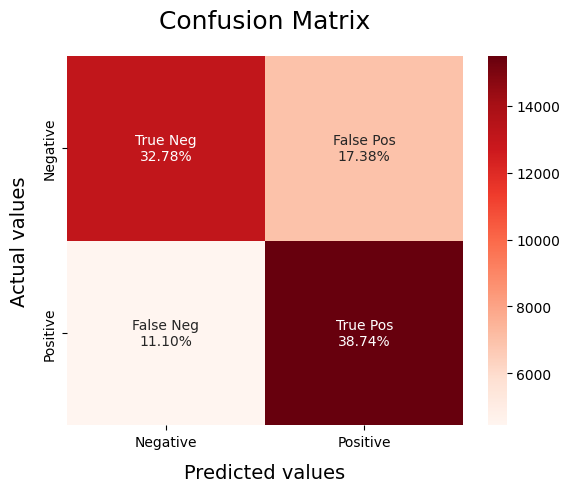

In [63]:
model_Evaluate(rf)

### 5.4 Naive Bayes

Accuracy of model on training data : 81.19125
Accuracy of model on testing data : 74.715 

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     20063
           1       0.75      0.75      0.75     19937

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



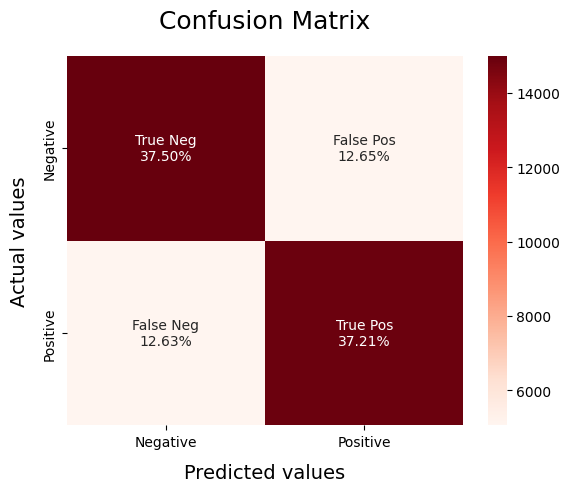

In [64]:
model_Evaluate(nb)

### 5.5 RNN

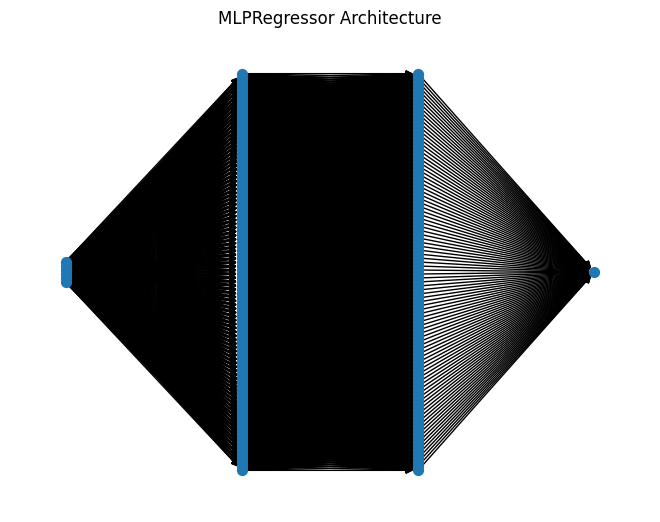

In [ ]:
model_Evaluate(rnn)

## 6.0 Deployment

Paper: ComfortJDDS8536-6 - England Temperature Forecast Using a Multilayer Perceptron Regressor